In [1]:
import numpy as np
# Train a model to classify real pulses vs. noise
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import awkward as ak
from tensorflow.keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
num_events = 50000
num_samples = 10
xmin = 1
xmax = 10

In [3]:
np.linspace(xmin, xmax, 10)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [4]:
def plot_timesamples(ax, time, emsignal_list, noisedata_list):
    #fig, ax = plt.subplots()
    for i, emsignal in enumerate(emsignal_list):
        noisedata = noisedata_list[i][1:]
        ax.plot(time, emsignal[1:], label=f'EM pulse' if i==1 else None, color='blue')
        ax.plot(time, noisedata, label=f'noise'  if i==1 else None,color='orange')
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Amplitude (arb. units)')
    ax.legend()

In [26]:
import uproot
### Energy = 0.15 GeV

root_file = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/outputPSWithPU_withNoise_0.150000_0.15_v10.root")
tree = root_file["Samples"]
arrays = tree.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise"])
X_real = ak.to_numpy(arrays["samples"])
y_real = ak.to_numpy(arrays["ysamples"])
X_noise = ak.to_numpy(arrays["samplesNoise"])
y_noise = ak.to_numpy(arrays["ysamplesNoise"])

print(X_real) 
print("Printing y_real")
print(y_real)

data = np.concatenate([X_real, X_noise]) ### makes it [2*num_events,num_samples]
labels = np.concatenate([y_real,y_noise])

# Shuffle data and labels together
## Important to shuffle since I take some fraction of events so it should not happen that all the real events 
## are cluttered at the beginning
shuffle_indices = np.random.permutation(len(data))
data = data[shuffle_indices]
labels = labels[shuffle_indices]

#fig, ax = plt.subplots()
import awkward as ak

num_events = ak.num(X_real, axis=0)
t_events = np.zeros((num_events, num_samples))
for i in range(num_events):
    t_event = np.linspace(xmin, xmax, 10)
    t_events[i] = t_event
###replace this block with actual time variable

#fig, ax = plt.subplots()
ev_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9 , 10, 100, 200, 300]# list of event numbers to plot
#ev_numbers = [1500]
#emsignal_list = [X_real[ev_number] for ev_number in ev_numbers]
#noisedata_list = [X_noise[ev_number] for ev_number in ev_numbers]
#plot_timesamples(ax, t_events[ev_numbers[0]], emsignal_list, noisedata_list)
#plt.show()

[[-0.13500901 -0.06486101 -0.24207319 ... -0.33857177 -0.65531789
  -0.59965165]
 [-1.         -0.44654846  0.04011444 ... -0.00468594  0.082898
   0.16267521]
 [ 0.12382481  0.06464252  0.20023386 ...  0.91687229  1.
   0.97295958]
 ...
 [ 0.03826011 -0.74802831 -0.74012889 ...  0.94438525  0.71223759
   0.53373214]
 [ 0.56940722  0.05372832  0.26732516 ...  0.17160948  0.07397752
  -0.28824042]
 [-0.43647409 -0.26998941  0.17765244 ...  0.76181932  0.87472013
   0.83904154]]
Printing y_real
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [27]:
import awkward as ak

num_events_data = ak.num(data, axis=0)
print(f'number of rows in data is {num_events_data}')


ntimeSamples_data = ak.num(data, axis=1)
print(f'number of rows in data is {ntimeSamples_data[0]}') ## just take the 0th event

# Split into train and test sets
train_size = int(0.7 * num_events_data) ###times 2 because the noise is also in the same dataset, so it is 2*num_events
train_data = data[:train_size]
train_labels = labels[:train_size]
test_data = data[train_size:]
test_labels = labels[train_size:]

print(f'Size of training data is {train_size}')

'''
print(train_size)
print(train_data)
print(test_data)
'''

print(f'number of elements in data : training data : test data : {len(data)} : {len(train_data)} : {len(test_data)}')

number of rows in data is 200000
number of rows in data is 11
Size of training data is 140000
number of elements in data : training data : test data : 200000 : 140000 : 60000


In [28]:
x_train = train_data
y_train = train_labels
#n_classes = len(np.unique(y_train))
x_test = test_data
y_test = test_labels

In [29]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [30]:
y_train = y_train.reshape((y_train.shape[0],1))
y_test = y_test.reshape((y_test.shape[0],1))

In [31]:
from tensorflow import keras
from tensorflow.keras import layers

In [32]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x,x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    #x = layers.LayerNormalization(epsilon=1e-6)(res)
    
    # Feed Forward Part
    #x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    #x = layers.Dropout(dropout)(x)
    #x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    #x = layers.Dropout(dropout)(x)
    #x = layers.LayerNormalization(epsilon=1e-6)(x + res)
    return res

In [33]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [34]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=10,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128,10],
    mlp_dropout=0.4,
    dropout=0.25,
)

#model.compile(
#    loss="sparse_categorical_crossentropy",
    #optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#    optimizer= "adam",
#    metrics=["sparse_categorical_accuracy"],
#)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=callbacks,
)
#model.save('/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/model/NoPUtimeSeries_transformer_model_v0_0.15.h5')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 11, 1)]      0           []                               
                                                                                                  
 layer_normalization_8 (LayerNo  (None, 11, 1)       2           ['input_3[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_8 (MultiH  (None, 11, 1)       17921       ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                                            

2023-07-15 15:54:53.689656: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 151.2KiB (rounded to 154880)requested by op model_2/multi_head_attention_11/einsum/Einsum
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-07-15 15:54:53.690360: W tensorflow/core/common_runtime/bfc_allocator.cc:474] ********************************xx*****************************************************************x
2023-07-15 15:54:53.690873: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at einsum_op_impl.h:643 : RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[32,10,11,11] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc


ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/multi_head_attention_11/einsum/Einsum' defined at (most recent call last):
    File "/usr/local/bin/start_ipykernel.py", line 6, in <module>
      app.launch_new_instance()
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/traitlets/config/application.py", line 845, in launch_instance
      app.start()
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 667, in start
      self.io_loop.start()
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 456, in dispatch_queue
      await self.process_one()
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 445, in process_one
      await dispatch(*args)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 352, in dispatch_shell
      await result
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 647, in execute_request
      reply_content = await reply_content
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 345, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2898, in run_cell
      result = self._run_cell(
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2944, in _run_cell
      return runner(coro)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3169, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1052/242041058.py", line 26, in <module>
      history = model.fit(
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/layers/multi_head_attention.py", line 510, in call
      attention_output, attention_scores = self._compute_attention(
    File "/cvmfs/sft.cern.ch/lcg/views/LCG_103cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/layers/multi_head_attention.py", line 472, in _compute_attention
      attention_scores = tf.einsum(self._dot_product_equation, key,
Node: 'model_2/multi_head_attention_11/einsum/Einsum'
OOM when allocating tensor with shape[32,10,11,11] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_2/multi_head_attention_11/einsum/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_566245]

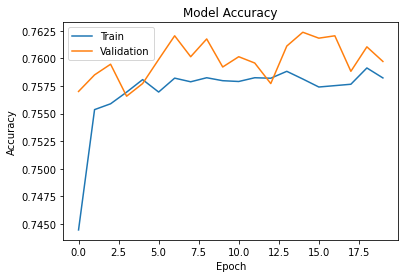

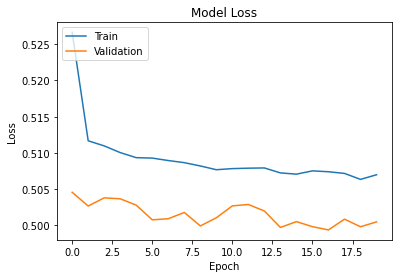

In [14]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

60000 and 60000
 predictions are [0.8403836  0.05256076 0.8088177  ... 0.6880501  0.55426216 0.40063846]


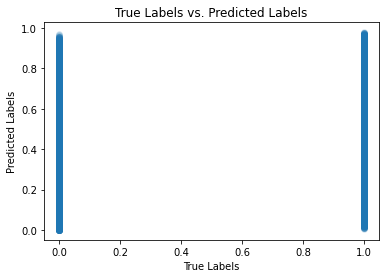

In [15]:
# Make predictions on test data
predictions = model.predict(x_test).flatten()
# Convert predictions to binary labels
binary_predictions = (predictions > 0.5).astype(int)

print(f'{len(y_test)} and {len(binary_predictions)}')
print(f" predictions are {predictions}")
# Create scatter plot of true labels vs. predicted labels
plt.scatter(y_test, predictions, alpha=0.1)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('True Labels vs. Predicted Labels')
plt.show()